# SWB Trend Prediction (Deep)

***Purpose***

- (1) 삶의 만족도가 증가하는 시점, 감소하는 시점 파악
- (2) 삶의 만족도가 증가할 때의 사용자 행동 패턴 파악
- (3) 삶의 만족도가 감소하는 시점에(1), 삶의 만족도가 증가할 때의 사용자 패턴을 추천(2) 

***undoing effect***
- 긍정적 정서가 부정적 정서의 영향 이후에 균형감, 유연성, 그리고 평정상태의 회복을 도와 불행한 효과를 빨리 사라지게 한다는 취소 효과(undoing effect)
****

- X (***all features are normalized for each user***)
    - Smartphone Features
        1. Activity
        2. App Usage
        3. Loc
        4. Sleep
    - Pre Survey 
    

- Y 
    - SWB Trend Prediction  :  전반적인 삶의 만족도 (COMOSWB) 점수를 기반으로 3일에 한번 측정한 값을 사용
        1. Increase : 이전 측정값에 비해 삶의 만족도가 증가한 경우
        2. Decrease : 이전 측정값에 비해 삶의 만족도가 감소한 경우
        3. No change : 이전 측정값과 동일한 경우

****
- Model
    - ARMA
    - ***RNN, LSTM***

In [1]:
import os, sys
file_dir = '/Users/imsoyoung/Soyoung/Ajou/Project/DigitalPhenotype/DigitalPhenotype_overall/Code/Util'
sys.path.append(os.path.dirname(os.path.abspath
                                (os.path.abspath(file_dir))))

import Util.Utility as util
from IPython.display import Image


In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt
import datetime
import seaborn as sns

from matplotlib import rc

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True 

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import collections

In [3]:
# !pip install sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier


import shap

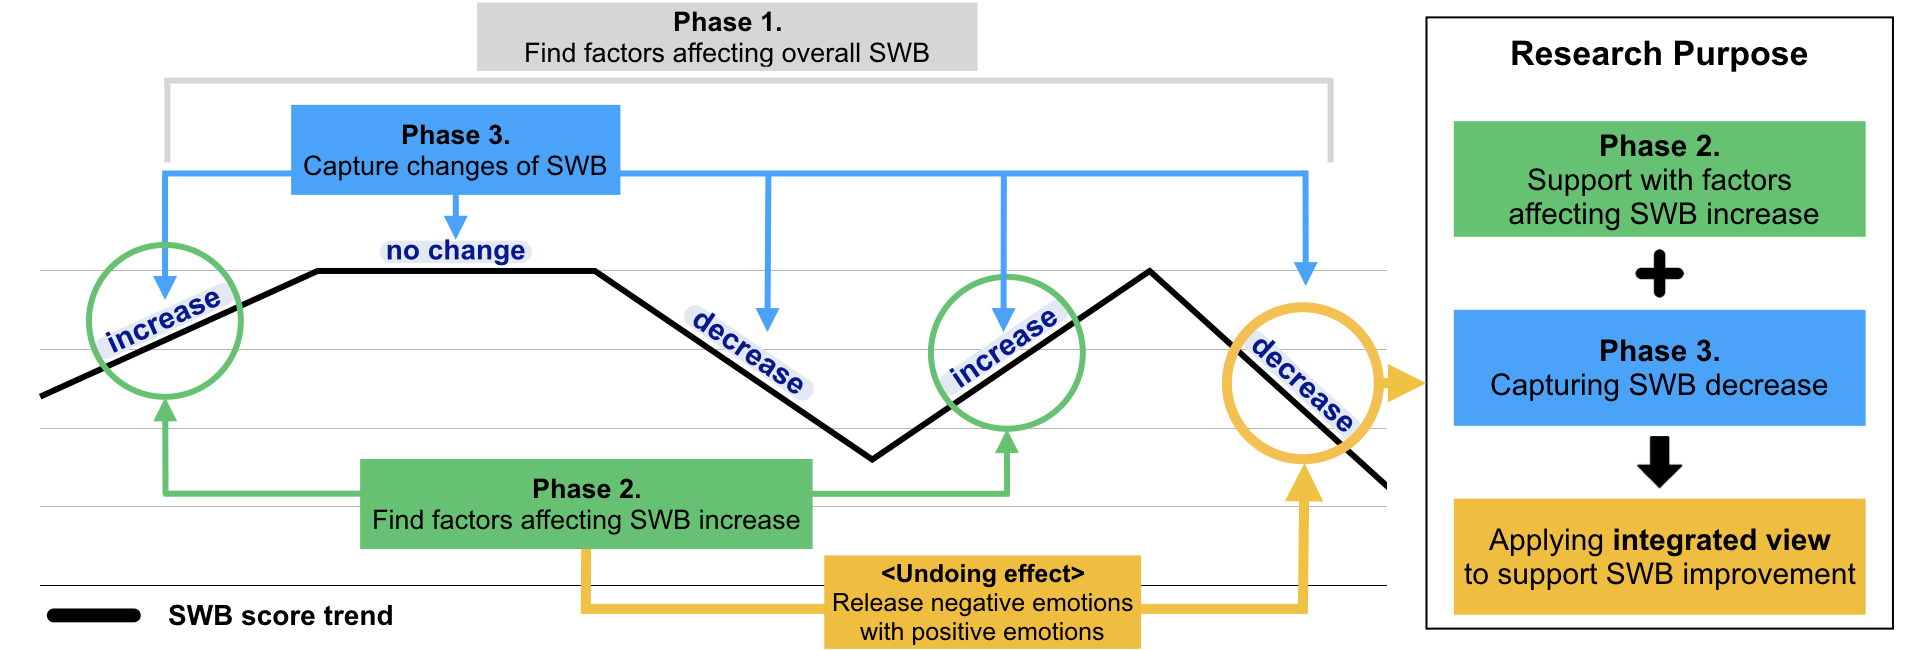

In [4]:
Image("../../img/DP_SWB_change.jpeg") 

In [5]:
def classification(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.20, random_state=42)

    pipelines = []

    pipelines.append(('RF', Pipeline([('RF',RandomForestClassifier())])))
    pipelines.append(('LR', Pipeline([('LR',LogisticRegression() )])))
    pipelines.append(('AB', Pipeline([('AB', AdaBoostClassifier(n_estimators=50,
                             learning_rate=1))])))


    results = []
    names = []
    tmp_df = pd.DataFrame(columns = ['model', 'accuracy', 'f1_micro', 'f1_macro'])
    
    for name, model in pipelines:
        kfold = KFold(n_splits=10)
        scoring = {'accuracy': 'accuracy',
           'f1_micro': 'f1_micro',
           'f1_macro': 'f1_macro'}
        
        cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring)

        results.append(cv_results)
        names.append(name)
        tmp_df = tmp_df.append({'model': name,'accuracy': cv_results['test_accuracy'].mean().mean(),
                               'f1_micro':cv_results['test_f1_micro'].mean().mean(),
                               'f1_macro': cv_results['test_f1_macro'].mean().mean()
                               }, ignore_index = True)
        

    return tmp_df

def getClassResult(normalized_df, allFeatures, ylabel, groupCol):

    ### 모든 유저의 모델 성능
    print("모든 유저")
    class_all = pd.DataFrame()
    
    X = normalized_df[allFeatures].values
    Y = normalized_df[ylabel].values
    class_all = classification(X, Y)

    ### 각 유저별 모델 성능
    class_each = pd.DataFrame()
    count = 0
    print("User 별")
    for user in set(normalized_df['uid']):
        count +=1
        print("{:.2f}".format(float(count)/len(set(normalized_df['uid']))*100), end = '\r')
        tmp = normalized_df[normalized_df['uid'] == user]
        X = tmp[allFeatures].values
        Y = tmp[ylabel].values
        tmp_each = classification(X, Y)
        tmp_each['uid'] = user
        class_each = pd.concat([class_each.reset_index(drop=True), tmp_each.reset_index(drop=True)])
    
    ### 각 그룹별 모델 성능
    class_group = pd.DataFrame()
    groups = set(normalized_df[groupCol])
    print("Group 별")
    for g in groups:
        group_df = swb[swb[groupCol]==g]
        X = group_df[allFeatures].values
        Y = group_df[ylabel].values
        tmp_group = classification(X, Y)
        tmp_group['SWB_level(Group)'] = g
        class_group = pd.concat([class_group.reset_index(drop=True), tmp_group.reset_index(drop=True)])
    
    return  class_all, class_each, class_group

In [6]:
swb = pd.read_csv('../../Sample_Data/Final/SWB_final.csv')
swb.head()

,Unnamed: 0,Unnamed: 0.1,timestamp,uid,gender,group,PPC,SAS,SWLS,BFI_EXT,...,sleep_duration,sleep_onset_abs,wake_up_abs,dayofWeek,SWB_score,label_3,POS,NEG,SAT,Measured
0,0,0,2017.9.10,20946596,0,1,1.0,39,23,10,...,0.399396,0.140638,0.317838,6,21.0,0,16,13,18,1
1,1,1,2017.9.11,20946596,0,1,1.0,39,23,10,...,0.613690,0.056220,0.340805,0,21.0,0,16,13,18,0
2,2,2,2017.9.12,20946596,0,1,1.0,39,23,10,...,0.571840,0.049202,0.311964,1,21.0,0,16,13,18,0
3,3,3,2017.9.13,20946596,0,1,1.0,39,23,10,...,0.658228,0.111161,0.420694,2,21.0,0,16,13,18,0
4,4,4,2017.9.14,20946596,0,1,1.0,39,23,10,...,0.332802,0.245503,0.392184,3,21.0,1,16,11,16,1


21.173531173064273 9.131897896299343
21.173531173064273 7.475684328615259 2.9097353804655874


(array([  6.,  23.,  63., 153., 291., 325., 419., 443., 292., 132.]),
 array([-10. ,  -5.1,  -0.2,   4.7,   9.6,  14.5,  19.4,  24.3,  29.2,
         34.1,  39. ]),
 <a list of 10 Patch objects>)

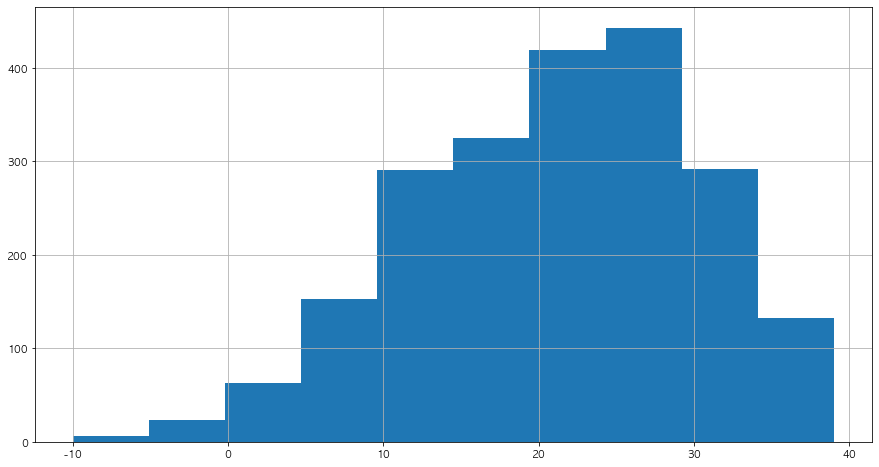

In [7]:
swb_response = swb[swb['Measured'] == 1]
swb_mean = swb_response['SWB_score'].mean()
swb_std = swb_response['SWB_score'].std()

print(swb_mean, swb_std)
print(swb_mean, swb_mean - 1.5 * swb_std, swb_mean - 2.0*swb_std)
plt.hist(swb_response['SWB_score'])


In [8]:
user_swb_group = pd.DataFrame(columns = ['uid', 'mean', 'SWB_level(group)'])

for uid in set(swb['uid']):
    user_df = swb[(swb['uid'] == uid) & (swb['Measured']==1)]
    user_mean = user_df['SWB_score'].mean()
    
    
    level = 0
    
    if user_mean >= swb_mean:
        level = 0
    elif (user_mean < swb_mean - 1.5*swb_std) and (user_mean > swb_mean - 2.0*swb_std):
        level = 1
    else:
        level = 2
        
    user_swb_group = user_swb_group.append({'uid':uid, 'mean':user_mean, 'SWB_level(group)':level}, ignore_index = True)
    

print(collections.Counter(user_swb_group['SWB_level(group)']))
user_swb_group.head()        


Counter({0.0: 41, 2.0: 35, 1.0: 2})


,uid,mean,SWB_level(group)
0,53789312.0,31.678571,0.0
1,75197570.0,8.250000,2.0
2,67973507.0,15.321429,2.0
3,22785668.0,29.107143,0.0
4,22682373.0,13.914286,2.0


In [9]:
user_swb_group['SWB_level(group)'] = user_swb_group['SWB_level(group)'].apply(lambda x : 1 if x >=1 else x)
print(collections.Counter(user_swb_group['SWB_level(group)']))

swb['SWB_level(group)'] = swb['uid'].apply(lambda x : user_swb_group[user_swb_group['uid'] == x]['SWB_level(group)'].values[0])



Counter({0.0: 41, 1.0: 37})


- Data 특성 : 시계열
    - 사람들의 SWB score 의 변화(Trend) 파악을 위해 LSTM 시도

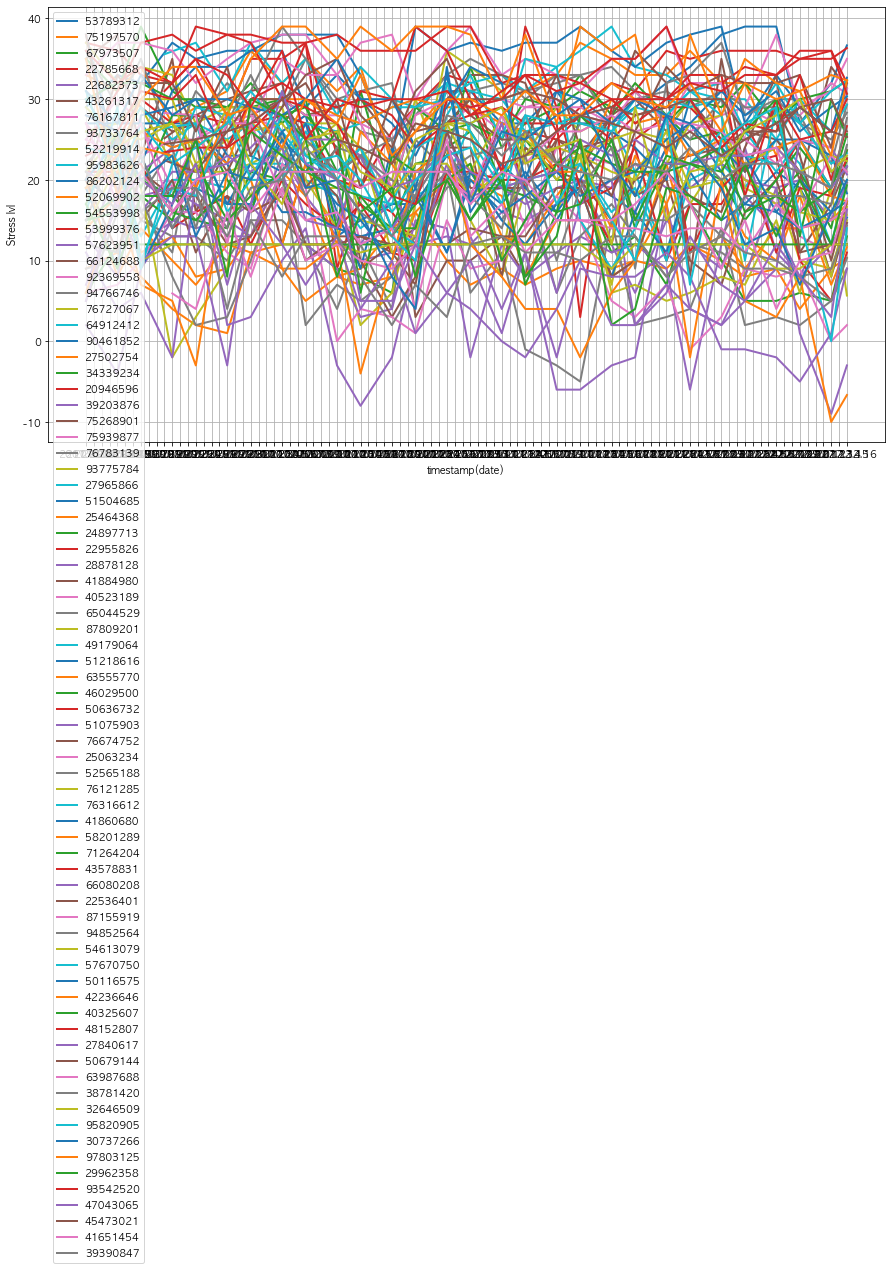

In [10]:
for uid in set(swb['uid']):
   
    user_Df = swb[swb['uid'] == uid]
        
    plt.plot(user_Df['timestamp'], user_Df['SWB_score'], label = uid)
    plt.xlabel('timestamp(date)')
    plt.ylabel('Stress lvl')
    plt.legend(loc = 'upper left')


## Using  statsmodel (ARMA)

- statsmode.ARMA 모형 (Auto-Regressive Integrated Moving-Average)      

    -  ***AR (자기상관 - Autocorrelation)*** 
        -  시계열 데이터 {Yt} 의 과거치(previous observation Y(t-1), Y(t-2)...)가 설명 변수인 모형
        - 이전의 값이 이후의 값에 영향을 미치는 경우
        
    -  ***MA (이동 평균 - Moving Average)*** 
        - 과거의 오차항(e(t-1), e(t-2))이 설명변수인 MA 모형
        - 시간이 지날수록 어떠한 Random Variable 의 평균값이 지속적으로 증가하거나 감소하는 경향이 있는 경우 (봄에서 여름이 될수록 가계 전기 수요량이 증가하는 경향이 있는 것처럼)
    
    - AR + MA

***
- AR 모형의 가설 : 과거의 패턴이 지속된다면 시계열 데이터 관측치 Y(t) 는 과거 관측치로 예측할 수 있을 것이다.
    - Q1. 얼마나 먼 과거 데이터까지 이용할 것인가?
    - Q2. 과거 데이터의 시간이 멀면 멀수록, 영향력은 줄어들 것이다   
    --> 이런 상황을 고려할 수 있는 가중치를 사용해야 하지 않을까?

- ARMA 모형
    - 과거, 현재의 분석에 대해서는 매우 정확
    - 시계열로 미래를 알 수 없지만, 미래에 대한 시나리오를 비교하는 데 쓸 수 있음
***
- statsmodel : [https://datascienceschool.net/view-notebook/77ee0e1bb6754ad89e0da14c6d461953/  ]
- ARMA : https://m.blog.naver.com/bluefish850/220749045909
- 시계열 분석 이론의 기초 : https://yamalab.tistory.com/112

In [11]:
# !pip install statsmodels

In [12]:
import statsmodels.api as sm

sample = swb[swb['uid'] == 22955826]
model_ARMA = sm.tsa.ARMA(sample["SWB_score"], (1,2))
result_ARMA = model_ARMA.fit()

print(result_ARMA.summary())

                              ARMA Model Results                              
Dep. Variable:              SWB_score   No. Observations:                   98
Model:                     ARMA(1, 2)   Log Likelihood                -195.759
Method:                       css-mle   S.D. of innovations              1.746
Date:                Mon, 30 Mar 2020   AIC                            401.518
Time:                        12:24:42   BIC                            414.443
Sample:                             0   HQIC                           406.746
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              28.0692      2.993      9.379      0.000      22.204      33.935
ar.L1.SWB_score     0.8668      0.050     17.191      0.000       0.768       0.966
ma.L1.SWB_score     0.7869      

An unsupported index was provided and will be ignored when e.g. forecasting.


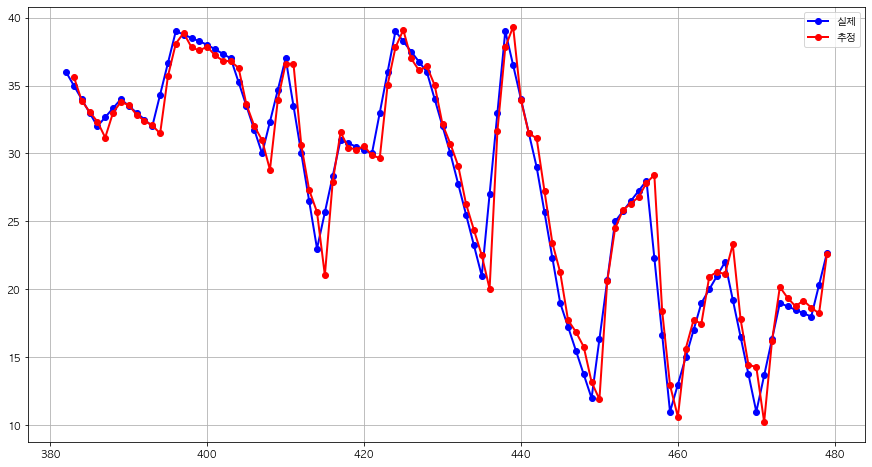

In [13]:
plt.plot(sample["SWB_score"], "bo-", label="실제")
plt.plot(result_ARMA.predict(1), "ro-", label="추정")
plt.legend()
plt.show()

## Using RNN (Keras)

In [14]:
# from tf.keras.models import Sequential # This does not work!
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [15]:
print(tf.__version__)
print(tf.keras.__version__)

1.15.0
2.2.4-tf


***시간 관련 컬럼 추가***

In [17]:
util.toDatetime(swb, ['timestamp'], "%Y%m%d") #to_datatime
swb = swb.iloc[:, 2:]
swb.head()

,timestamp,uid,gender,group,PPC,SAS,SWLS,BFI_EXT,BFI_CON,BFI_NEU,...,sleep_onset_abs,wake_up_abs,dayofWeek,SWB_score,label_3,POS,NEG,SAT,Measured,SWB_level(group)
0,2017-09-10,20946596,0,1,1.0,39,23,10,11,8,...,0.140638,0.317838,6,21.0,0,16,13,18,1,1.0
1,2017-09-11,20946596,0,1,1.0,39,23,10,11,8,...,0.056220,0.340805,0,21.0,0,16,13,18,0,1.0
2,2017-09-12,20946596,0,1,1.0,39,23,10,11,8,...,0.049202,0.311964,1,21.0,0,16,13,18,0,1.0
3,2017-09-13,20946596,0,1,1.0,39,23,10,11,8,...,0.111161,0.420694,2,21.0,0,16,13,18,0,1.0
4,2017-09-14,20946596,0,1,1.0,39,23,10,11,8,...,0.245503,0.392184,3,21.0,1,16,11,16,1,1.0


In [259]:
time_list = list(set(swb['timestamp']))
time_list.sort()
# print(time_list, "")
print(len(time_list))

98


In [19]:
# 사용자 스터디 전체 날짜 중 몇번째 날인지 (1 ~ 98)
swb['time_no'] = swb['timestamp'].apply(lambda x : time_list.index(x))
swb.head()

,timestamp,uid,gender,group,PPC,SAS,SWLS,BFI_EXT,BFI_CON,BFI_NEU,...,wake_up_abs,dayofWeek,SWB_score,label_3,POS,NEG,SAT,Measured,SWB_level(group),time_no
0,2017-09-10,20946596,0,1,1.0,39,23,10,11,8,...,0.317838,6,21.0,0,16,13,18,1,1.0,0
1,2017-09-11,20946596,0,1,1.0,39,23,10,11,8,...,0.340805,0,21.0,0,16,13,18,0,1.0,1
2,2017-09-12,20946596,0,1,1.0,39,23,10,11,8,...,0.311964,1,21.0,0,16,13,18,0,1.0,2
3,2017-09-13,20946596,0,1,1.0,39,23,10,11,8,...,0.420694,2,21.0,0,16,13,18,0,1.0,3
4,2017-09-14,20946596,0,1,1.0,39,23,10,11,8,...,0.392184,3,21.0,1,16,11,16,1,1.0,4


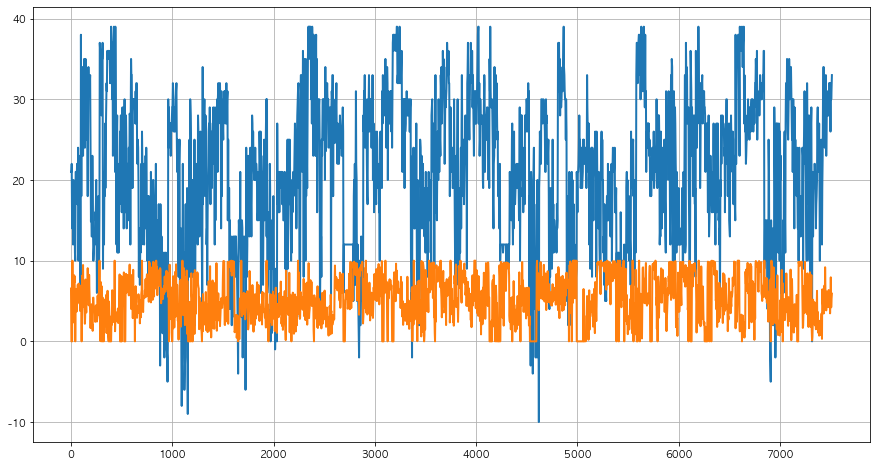

In [21]:
swb_measured = swb[swb['Measured']==1]
swb_measured['SWB_score'].plot()
(swb_measured['App_sum']*10).plot()

In [22]:
swb.isna().sum().sum()

0

In [23]:
len(set(swb['timestamp']))

98

In [147]:
user_info = ['uid', 'gender', 'group', 'SWB_level(group)', 'dayofWeek', 'time_no']

loc = ['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9','distance', 'move_cnt']
act = ['ratio_still_afternoon', 'ratio_still_evening', 'ratio_still_morning','still_total_all']
app = ['App_sum', 'Art&Design&Photo', 'Bank&Purchase',
       'Books & Reference', 'Educational', 'Entertainment&Music',
       'Food & Drink', 'Games&Comics', 'News & Magazines',
       'Others', 'Shopping', 'Social&Communication', 'Travel', 'Utilities',
       'Weather', 
         'afternoon screenOn', 'evening screenOn', 'morning screenOn']
sleep = ['sleep_duration', 'sleep_onset_abs', 
         'wake_up_abs']

y_reg = ['SWB_score']
y_cls = ['SWB_score']

features = user_info + loc + act + app + sleep


print(len(features))

44


### Sample User

#### ***Split 기준 설정하여 Train/Test 나누기***

In [200]:
time_series = list(set(swb['time_no']))
split_index = int(len(time_series) * 0.8)

split_timeNo = time_series[split_index]
print(len(time_series), split_timeNo)

# swb[swb['time_no']==split_timeNo].head() # 2017/11/27 까지 Train

98 78


In [251]:
train = pd.DataFrame()
test = pd.DataFrame()

for uid in set(swb_df['uid']):
    user_df = swb_df[swb_df['uid'] == uid]
    
    user_train = user_df[user_df['time_no'] <= split_timeNo]
    user_test = user_df[user_df['time_no'] > split_timeNo]
    
    train = pd.concat([train.reset_index(drop=True), user_train.reset_index(drop=True) ])
    
    test = pd.concat([test.reset_index(drop=True), user_test.reset_index(drop=True) ])
    

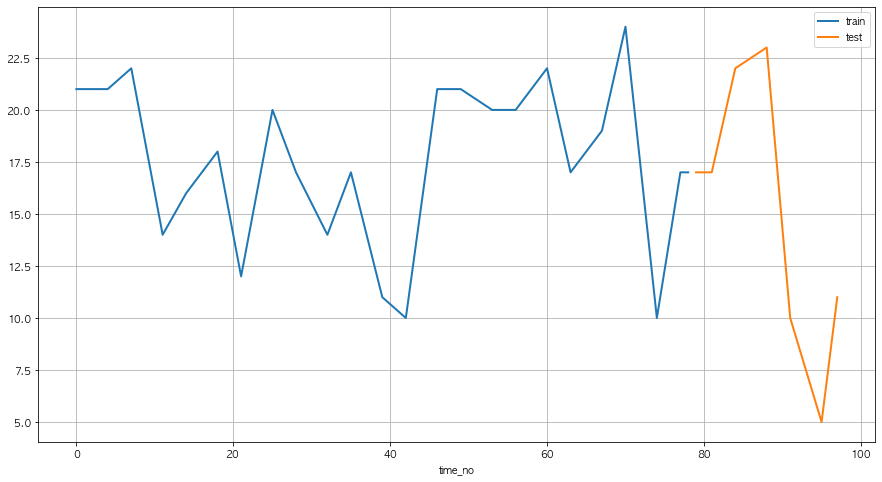

In [252]:
sample_uid = 20946596
train_sample = train[train['uid'] == sample_uid]
test_sample = test[test['uid'] == sample_uid]

train_sample.index = train_sample['time_no']
test_sample.index = test_sample['time_no']

train_sub = train_sample['SWB_score']
test_sub = test_sample['SWB_score']


ax = train_sub.plot()
test_sub.plot(ax=ax)
plt.legend(['train', 'test'])


#### ***Sliding window (Shift)***

window가 7개라면 과거 시간 데이터 7개를 사용해서 다음 시간 단위의 값을 예측하게 됨. 

- 과거 7일의 데이터로 현재의 SWB Trend (or SCORE) 예측
- 각 유저별 모델 생성

cf. https://twinparadox.tistory.com/595


#### X, y 정의 
1. Regression (SWB_score)
2. Classification (label_3)

#### keras 의 LSTM 에서 필요로 하는 3차원 데이터로 변환! 

- 최종 data shape = (size, timestamp, feature)

In [253]:
# build datasets : Sliding window (Shift)
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [254]:
# for uid in set(swb['uid']):
sample_uid = 20946596

sample_train = train[train['uid'] == sample_uid]
sample_test = test[test['uid'] == sample_uid]

sample_train = sample_train.drop('uid', axis=1)
sample_test = sample_test.drop('uid', axis=1)



sample_train.head()
print(sample_train.shape)

(79, 44)


In [255]:
sample_train = sample_train.values
sample_test = sample_test.values

# train Parameters
seq_length = 7 # == timesteps ==> 이전 7일의 데이터로 8일 째의 SWB 를 예측하겠다.
data_dim = sample_train.shape[1]
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 10000

## Sliding Window
trainX, trainY = build_dataset(sample_train, seq_length)
testX, testY = build_dataset(sample_test, seq_length)

[[0.00000000e+00 1.00000000e+00 1.00000000e+00 6.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.63636364e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 6.36363636e-01
  3.07987520e-01 5.00000000e-02 4.21557252e-01 4.80348105e-01
  7.87500000e-01 5.55189456e-01 6.54676259e-01 0.00000000e+00
  4.75863420e-02 5.10204080e-02 0.00000000e+00 3.21605814e-01
  1.00000000e+00 1.81318681e-01 0.00000000e+00 0.00000000e+00
  8.37912088e-01 8.29670330e-01 0.00000000e+00 3.63736264e-01
  0.00000000e+00 6.52380952e-01 1.34529148e-01 1.29310345e-01
  3.99395684e-01 1.40637573e-01 3.17837917e-01 2.10000000e+01]
 [0.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 1.01368760e-02 9.94555354e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.14061130e-02 2.00000000e-01 6.60394548e-01 2.77205974e-01
  8.143

  4.30705908e-01 1.72646377e-01 3.67144486e-01 2.27500000e+01]] -> [23.]
[[0.00000000e+00 1.00000000e+00 1.00000000e+00 4.00000000e+00
  8.20000000e+01 0.00000000e+00 1.01614656e-01 8.90842935e-01
  1.01244437e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.51728320e-02
  2.96196485e-01 1.50000000e-01 7.42210608e-01 1.85956535e-01
  8.41801386e-01 6.77100494e-01 3.43525180e-01 0.00000000e+00
  7.25504860e-02 2.77807458e-01 0.00000000e+00 1.00000000e+00
  0.00000000e+00 9.21465970e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 6.85863874e-01 0.00000000e+00 1.73298429e-01
  0.00000000e+00 4.33333333e-01 4.79820628e-01 2.02586207e-01
  5.93609479e-01 1.36981114e-01 4.14145749e-01 1.86666667e+01]
 [0.00000000e+00 1.00000000e+00 1.00000000e+00 5.00000000e+00
  8.30000000e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.23167581e-01 0.00000000e+00 9.76392252e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e

In [256]:
data_dim

44

In [257]:
tf.reset_default_graph()

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)

outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares

# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))



[step: 0] loss: 21876.36328125
[step: 1] loss: 21647.12109375
[step: 2] loss: 21398.01953125
[step: 3] loss: 21129.97265625
[step: 4] loss: 20850.859375
[step: 5] loss: 20546.75
[step: 6] loss: 20158.416015625
[step: 7] loss: 19629.09765625
[step: 8] loss: 18950.228515625
[step: 9] loss: 18187.3828125
[step: 10] loss: 17452.22265625
[step: 11] loss: 16815.0
[step: 12] loss: 16266.65234375
[step: 13] loss: 15778.90625
[step: 14] loss: 15341.7939453125
[step: 15] loss: 14931.4130859375
[step: 16] loss: 14520.1630859375
[step: 17] loss: 14119.328125
[step: 18] loss: 13784.560546875
[step: 19] loss: 13539.056640625
[step: 20] loss: 13333.697265625
[step: 21] loss: 13135.4921875
[step: 22] loss: 12927.052734375
[step: 23] loss: 12709.267578125
[step: 24] loss: 12495.9326171875
[step: 25] loss: 12290.77734375
[step: 26] loss: 12095.1201171875
[step: 27] loss: 11924.8544921875
[step: 28] loss: 11764.7822265625
[step: 29] loss: 11609.2021484375
[step: 30] loss: 11455.5234375
[step: 31] loss: 1

[step: 277] loss: 782.1978759765625
[step: 278] loss: 782.1668701171875
[step: 279] loss: 782.1377563476562
[step: 280] loss: 782.1104736328125
[step: 281] loss: 782.0849609375
[step: 282] loss: 782.0609741210938
[step: 283] loss: 782.0384521484375
[step: 284] loss: 782.017333984375
[step: 285] loss: 781.99755859375
[step: 286] loss: 781.9788818359375
[step: 287] loss: 781.9616088867188
[step: 288] loss: 781.9453125
[step: 289] loss: 781.9300537109375
[step: 290] loss: 781.915771484375
[step: 291] loss: 781.9024047851562
[step: 292] loss: 781.889892578125
[step: 293] loss: 781.878173828125
[step: 294] loss: 781.8671264648438
[step: 295] loss: 781.85693359375
[step: 296] loss: 781.8472900390625
[step: 297] loss: 781.83837890625
[step: 298] loss: 781.8299560546875
[step: 299] loss: 781.822021484375
[step: 300] loss: 781.814697265625
[step: 301] loss: 781.8077392578125
[step: 302] loss: 781.8013916015625
[step: 303] loss: 781.7952880859375
[step: 304] loss: 781.7897338867188
[step: 305] l

[step: 544] loss: 249.65725708007812
[step: 545] loss: 248.1707305908203
[step: 546] loss: 246.71298217773438
[step: 547] loss: 245.29006958007812
[step: 548] loss: 243.90386962890625
[step: 549] loss: 242.55540466308594
[step: 550] loss: 241.2429656982422
[step: 551] loss: 239.9609375
[step: 552] loss: 238.70143127441406
[step: 553] loss: 237.4613037109375
[step: 554] loss: 236.24612426757812
[step: 555] loss: 235.0645751953125
[step: 556] loss: 233.9191436767578
[step: 557] loss: 232.80587768554688
[step: 558] loss: 231.71768188476562
[step: 559] loss: 230.6500244140625
[step: 560] loss: 229.60195922851562
[step: 561] loss: 228.57374572753906
[step: 562] loss: 227.56637573242188
[step: 563] loss: 226.58140563964844
[step: 564] loss: 225.6192169189453
[step: 565] loss: 224.6794891357422
[step: 566] loss: 223.759033203125
[step: 567] loss: 222.8557891845703
[step: 568] loss: 221.96893310546875
[step: 569] loss: 221.09893798828125
[step: 570] loss: 220.24661254882812
[step: 571] loss: 2

[step: 808] loss: 81.21485900878906
[step: 809] loss: 81.0369873046875
[step: 810] loss: 80.85983276367188
[step: 811] loss: 80.68339538574219
[step: 812] loss: 80.50772857666016
[step: 813] loss: 80.3327865600586
[step: 814] loss: 80.15851593017578
[step: 815] loss: 79.98484802246094
[step: 816] loss: 79.81196594238281
[step: 817] loss: 79.6397476196289
[step: 818] loss: 79.4681396484375
[step: 819] loss: 79.29721069335938
[step: 820] loss: 79.12696838378906
[step: 821] loss: 78.957275390625
[step: 822] loss: 78.78825378417969
[step: 823] loss: 78.61985778808594
[step: 824] loss: 78.45214080810547
[step: 825] loss: 78.28497314453125
[step: 826] loss: 78.11834716796875
[step: 827] loss: 77.95233154296875
[step: 828] loss: 77.78695678710938
[step: 829] loss: 77.62210083007812
[step: 830] loss: 77.45774841308594
[step: 831] loss: 77.2940902709961
[step: 832] loss: 77.1308822631836
[step: 833] loss: 76.96822357177734
[step: 834] loss: 76.80609893798828
[step: 835] loss: 76.64450073242188


[step: 1068] loss: 48.45237350463867
[step: 1069] loss: 48.372013092041016
[step: 1070] loss: 48.29199981689453
[step: 1071] loss: 48.21235275268555
[step: 1072] loss: 48.13298797607422
[step: 1073] loss: 48.053680419921875
[step: 1074] loss: 47.974525451660156
[step: 1075] loss: 47.895469665527344
[step: 1076] loss: 47.81652069091797
[step: 1077] loss: 47.73772430419922
[step: 1078] loss: 47.65916442871094
[step: 1079] loss: 47.58081817626953
[step: 1080] loss: 47.502655029296875
[step: 1081] loss: 47.42481231689453
[step: 1082] loss: 47.34713363647461
[step: 1083] loss: 47.269710540771484
[step: 1084] loss: 47.19257736206055
[step: 1085] loss: 47.11569595336914
[step: 1086] loss: 47.03908157348633
[step: 1087] loss: 46.9627685546875
[step: 1088] loss: 46.88667297363281
[step: 1089] loss: 46.81084060668945
[step: 1090] loss: 46.735145568847656
[step: 1091] loss: 46.659725189208984
[step: 1092] loss: 46.58442306518555
[step: 1093] loss: 46.50925064086914
[step: 1094] loss: 46.434181213

[step: 1292] loss: 22.968177795410156
[step: 1293] loss: 22.896432876586914
[step: 1294] loss: 22.825450897216797
[step: 1295] loss: 22.755199432373047
[step: 1296] loss: 22.685707092285156
[step: 1297] loss: 22.61693572998047
[step: 1298] loss: 22.548866271972656
[step: 1299] loss: 22.481529235839844
[step: 1300] loss: 22.414886474609375
[step: 1301] loss: 22.348899841308594
[step: 1302] loss: 22.283599853515625
[step: 1303] loss: 22.21900177001953
[step: 1304] loss: 22.15498924255371
[step: 1305] loss: 22.091644287109375
[step: 1306] loss: 22.028955459594727
[step: 1307] loss: 21.966854095458984
[step: 1308] loss: 21.905376434326172
[step: 1309] loss: 21.84446907043457
[step: 1310] loss: 21.784183502197266
[step: 1311] loss: 21.724475860595703
[step: 1312] loss: 21.665327072143555
[step: 1313] loss: 21.606752395629883
[step: 1314] loss: 21.548721313476562
[step: 1315] loss: 21.491243362426758
[step: 1316] loss: 21.434303283691406
[step: 1317] loss: 21.37788200378418
[step: 1318] loss

[step: 1511] loss: 14.686788558959961
[step: 1512] loss: 14.654322624206543
[step: 1513] loss: 14.618638038635254
[step: 1514] loss: 14.585036277770996
[step: 1515] loss: 14.548213005065918
[step: 1516] loss: 14.513920783996582
[step: 1517] loss: 14.477027893066406
[step: 1518] loss: 14.441500663757324
[step: 1519] loss: 14.40394115447998
[step: 1520] loss: 14.36746597290039
[step: 1521] loss: 14.33024787902832
[step: 1522] loss: 14.293176651000977
[step: 1523] loss: 14.255419731140137
[step: 1524] loss: 14.217086791992188
[step: 1525] loss: 14.178787231445312
[step: 1526] loss: 14.139786720275879
[step: 1527] loss: 14.100920677185059
[step: 1528] loss: 14.061112403869629
[step: 1529] loss: 14.021684646606445
[step: 1530] loss: 13.981500625610352
[step: 1531] loss: 13.94168758392334
[step: 1532] loss: 13.90117359161377
[step: 1533] loss: 13.860870361328125
[step: 1534] loss: 13.820094108581543
[step: 1535] loss: 13.77945327758789
[step: 1536] loss: 13.738479614257812
[step: 1537] loss:

[step: 1776] loss: 7.3889312744140625
[step: 1777] loss: 7.372372627258301
[step: 1778] loss: 7.355904579162598
[step: 1779] loss: 7.339479923248291
[step: 1780] loss: 7.323153495788574
[step: 1781] loss: 7.306885242462158
[step: 1782] loss: 7.290688514709473
[step: 1783] loss: 7.274570941925049
[step: 1784] loss: 7.258515357971191
[step: 1785] loss: 7.242536544799805
[step: 1786] loss: 7.2266387939453125
[step: 1787] loss: 7.210784912109375
[step: 1788] loss: 7.195021152496338
[step: 1789] loss: 7.1793107986450195
[step: 1790] loss: 7.163674354553223
[step: 1791] loss: 7.148107528686523
[step: 1792] loss: 7.1326093673706055
[step: 1793] loss: 7.117171287536621
[step: 1794] loss: 7.101806640625
[step: 1795] loss: 7.086492538452148
[step: 1796] loss: 7.071256637573242
[step: 1797] loss: 7.056081295013428
[step: 1798] loss: 7.040953159332275
[step: 1799] loss: 7.02592134475708
[step: 1800] loss: 7.010937690734863
[step: 1801] loss: 6.996016502380371
[step: 1802] loss: 6.981147289276123
[

[step: 2002] loss: 4.898183822631836
[step: 2003] loss: 4.890867233276367
[step: 2004] loss: 4.883580207824707
[step: 2005] loss: 4.876326084136963
[step: 2006] loss: 4.869086265563965
[step: 2007] loss: 4.861856460571289
[step: 2008] loss: 4.8546576499938965
[step: 2009] loss: 4.847481727600098
[step: 2010] loss: 4.840319633483887
[step: 2011] loss: 4.833186149597168
[step: 2012] loss: 4.826066493988037
[step: 2013] loss: 4.818962097167969
[step: 2014] loss: 4.811888694763184
[step: 2015] loss: 4.804825305938721
[step: 2016] loss: 4.79779577255249
[step: 2017] loss: 4.790774822235107
[step: 2018] loss: 4.783782958984375
[step: 2019] loss: 4.776808738708496
[step: 2020] loss: 4.769852638244629
[step: 2021] loss: 4.76291036605835
[step: 2022] loss: 4.755993843078613
[step: 2023] loss: 4.749093055725098
[step: 2024] loss: 4.742209434509277
[step: 2025] loss: 4.735351085662842
[step: 2026] loss: 4.7285075187683105
[step: 2027] loss: 4.721685409545898
[step: 2028] loss: 4.7148823738098145


[step: 2264] loss: 3.491469621658325
[step: 2265] loss: 3.4874448776245117
[step: 2266] loss: 3.4834232330322266
[step: 2267] loss: 3.479410171508789
[step: 2268] loss: 3.4753975868225098
[step: 2269] loss: 3.4714126586914062
[step: 2270] loss: 3.467416524887085
[step: 2271] loss: 3.463433027267456
[step: 2272] loss: 3.4594533443450928
[step: 2273] loss: 3.4554758071899414
[step: 2274] loss: 3.45151686668396
[step: 2275] loss: 3.447561740875244
[step: 2276] loss: 3.4436092376708984
[step: 2277] loss: 3.4396541118621826
[step: 2278] loss: 3.435720205307007
[step: 2279] loss: 3.431791305541992
[step: 2280] loss: 3.427870750427246
[step: 2281] loss: 3.423940420150757
[step: 2282] loss: 3.420034646987915
[step: 2283] loss: 3.4161295890808105
[step: 2284] loss: 3.4122331142425537
[step: 2285] loss: 3.4083406925201416
[step: 2286] loss: 3.4044556617736816
[step: 2287] loss: 3.4005720615386963
[step: 2288] loss: 3.3966944217681885
[step: 2289] loss: 3.392836093902588
[step: 2290] loss: 3.3889

[step: 2527] loss: 2.6161341667175293
[step: 2528] loss: 2.613405704498291
[step: 2529] loss: 2.6106772422790527
[step: 2530] loss: 2.607964277267456
[step: 2531] loss: 2.605250835418701
[step: 2532] loss: 2.6025328636169434
[step: 2533] loss: 2.5998377799987793
[step: 2534] loss: 2.597136974334717
[step: 2535] loss: 2.5944409370422363
[step: 2536] loss: 2.5917470455169678
[step: 2537] loss: 2.589055299758911
[step: 2538] loss: 2.586371660232544
[step: 2539] loss: 2.583693504333496
[step: 2540] loss: 2.5810203552246094
[step: 2541] loss: 2.578359842300415
[step: 2542] loss: 2.575685501098633
[step: 2543] loss: 2.5730221271514893
[step: 2544] loss: 2.570371150970459
[step: 2545] loss: 2.567716598510742
[step: 2546] loss: 2.5650651454925537
[step: 2547] loss: 2.562427520751953
[step: 2548] loss: 2.559784412384033
[step: 2549] loss: 2.557154655456543
[step: 2550] loss: 2.554523468017578
[step: 2551] loss: 2.551896095275879
[step: 2552] loss: 2.549272298812866
[step: 2553] loss: 2.54666090

[step: 2746] loss: 2.1184418201446533
[step: 2747] loss: 2.1165690422058105
[step: 2748] loss: 2.1147074699401855
[step: 2749] loss: 2.112839460372925
[step: 2750] loss: 2.110976457595825
[step: 2751] loss: 2.109117031097412
[step: 2752] loss: 2.1072521209716797
[step: 2753] loss: 2.105400323867798
[step: 2754] loss: 2.103545665740967
[step: 2755] loss: 2.101698637008667
[step: 2756] loss: 2.0998589992523193
[step: 2757] loss: 2.0980143547058105
[step: 2758] loss: 2.0961740016937256
[step: 2759] loss: 2.0943379402160645
[step: 2760] loss: 2.0925073623657227
[step: 2761] loss: 2.0906758308410645
[step: 2762] loss: 2.0888466835021973
[step: 2763] loss: 2.0870161056518555
[step: 2764] loss: 2.0852012634277344
[step: 2765] loss: 2.083381414413452
[step: 2766] loss: 2.0815703868865967
[step: 2767] loss: 2.079759120941162
[step: 2768] loss: 2.077950954437256
[step: 2769] loss: 2.076139450073242
[step: 2770] loss: 2.07433819770813
[step: 2771] loss: 2.072544574737549
[step: 2772] loss: 2.0707

[step: 2970] loss: 1.7658995389938354
[step: 2971] loss: 1.764572024345398
[step: 2972] loss: 1.7632473707199097
[step: 2973] loss: 1.761929988861084
[step: 2974] loss: 1.7606104612350464
[step: 2975] loss: 1.759286880493164
[step: 2976] loss: 1.757975697517395
[step: 2977] loss: 1.756657361984253
[step: 2978] loss: 1.755347728729248
[step: 2979] loss: 1.7540361881256104
[step: 2980] loss: 1.7527236938476562
[step: 2981] loss: 1.7514221668243408
[step: 2982] loss: 1.7501177787780762
[step: 2983] loss: 1.7488114833831787
[step: 2984] loss: 1.7475154399871826
[step: 2985] loss: 1.7462146282196045
[step: 2986] loss: 1.7449144124984741
[step: 2987] loss: 1.7436201572418213
[step: 2988] loss: 1.7423198223114014
[step: 2989] loss: 1.7410311698913574
[step: 2990] loss: 1.7397388219833374
[step: 2991] loss: 1.7384454011917114
[step: 2992] loss: 1.7371646165847778
[step: 2993] loss: 1.7358763217926025
[step: 2994] loss: 1.7345988750457764
[step: 2995] loss: 1.7333165407180786
[step: 2996] loss:

[step: 3187] loss: 1.5164730548858643
[step: 3188] loss: 1.5154643058776855
[step: 3189] loss: 1.5144598484039307
[step: 3190] loss: 1.5134583711624146
[step: 3191] loss: 1.512450933456421
[step: 3192] loss: 1.5114468336105347
[step: 3193] loss: 1.5104470252990723
[step: 3194] loss: 1.5094430446624756
[step: 3195] loss: 1.5084478855133057
[step: 3196] loss: 1.5074501037597656
[step: 3197] loss: 1.5064537525177002
[step: 3198] loss: 1.505455493927002
[step: 3199] loss: 1.5044602155685425
[step: 3200] loss: 1.5034650564193726
[step: 3201] loss: 1.5024713277816772
[step: 3202] loss: 1.501481294631958
[step: 3203] loss: 1.500488042831421
[step: 3204] loss: 1.499500036239624
[step: 3205] loss: 1.4985108375549316
[step: 3206] loss: 1.4975253343582153
[step: 3207] loss: 1.4965331554412842
[step: 3208] loss: 1.4955520629882812
[step: 3209] loss: 1.4945683479309082
[step: 3210] loss: 1.4935827255249023
[step: 3211] loss: 1.4926040172576904
[step: 3212] loss: 1.4916222095489502
[step: 3213] loss

[step: 3415] loss: 1.3115226030349731
[step: 3416] loss: 1.3109617233276367
[step: 3417] loss: 1.3105764389038086
[step: 3418] loss: 1.3104650974273682
[step: 3419] loss: 1.3108301162719727
[step: 3420] loss: 1.3119884729385376
[step: 3421] loss: 1.3144903182983398
[step: 3422] loss: 1.3193211555480957
[step: 3423] loss: 1.3280125856399536
[step: 3424] loss: 1.3434324264526367
[step: 3425] loss: 1.369509220123291
[step: 3426] loss: 1.4135956764221191
[step: 3427] loss: 1.4820165634155273
[step: 3428] loss: 1.5847442150115967
[step: 3429] loss: 1.7080192565917969
[step: 3430] loss: 1.8263099193572998
[step: 3431] loss: 1.8455309867858887
[step: 3432] loss: 1.7276568412780762
[step: 3433] loss: 1.4953150749206543
[step: 3434] loss: 1.3228960037231445
[step: 3435] loss: 1.3146337270736694
[step: 3436] loss: 1.4321930408477783
[step: 3437] loss: 1.550716757774353
[step: 3438] loss: 1.5526201725006104
[step: 3439] loss: 1.438963532447815
[step: 3440] loss: 1.3165184259414673
[step: 3441] lo

[step: 3632] loss: 1.4035331010818481
[step: 3633] loss: 1.3207987546920776
[step: 3634] loss: 1.193503737449646
[step: 3635] loss: 1.142533540725708
[step: 3636] loss: 1.1906421184539795
[step: 3637] loss: 1.2685242891311646
[step: 3638] loss: 1.2976469993591309
[step: 3639] loss: 1.2452783584594727
[step: 3640] loss: 1.1705372333526611
[step: 3641] loss: 1.1384369134902954
[step: 3642] loss: 1.1644446849822998
[step: 3643] loss: 1.2082163095474243
[step: 3644] loss: 1.2186909914016724
[step: 3645] loss: 1.1876425743103027
[step: 3646] loss: 1.146005392074585
[step: 3647] loss: 1.1327770948410034
[step: 3648] loss: 1.1502798795700073
[step: 3649] loss: 1.1716642379760742
[step: 3650] loss: 1.172744870185852
[step: 3651] loss: 1.15230393409729
[step: 3652] loss: 1.1323961019515991
[step: 3653] loss: 1.1286194324493408
[step: 3654] loss: 1.1389387845993042
[step: 3655] loss: 1.1496583223342896
[step: 3656] loss: 1.1481550931930542
[step: 3657] loss: 1.1363751888275146
[step: 3658] loss:

[step: 3851] loss: 0.986751914024353
[step: 3852] loss: 0.9799666404724121
[step: 3853] loss: 0.9761296510696411
[step: 3854] loss: 0.9777591228485107
[step: 3855] loss: 0.9805431365966797
[step: 3856] loss: 0.980566680431366
[step: 3857] loss: 0.9772390127182007
[step: 3858] loss: 0.9731152057647705
[step: 3859] loss: 0.9716778993606567
[step: 3860] loss: 0.9725748300552368
[step: 3861] loss: 0.9735410213470459
[step: 3862] loss: 0.9728715419769287
[step: 3863] loss: 0.9703122973442078
[step: 3864] loss: 0.9678963422775269
[step: 3865] loss: 0.9669793844223022
[step: 3866] loss: 0.9671400785446167
[step: 3867] loss: 0.9673234224319458
[step: 3868] loss: 0.9664454460144043
[step: 3869] loss: 0.9647107720375061
[step: 3870] loss: 0.9631134271621704
[step: 3871] loss: 0.9621702432632446
[step: 3872] loss: 0.9618889689445496
[step: 3873] loss: 0.9616484642028809
[step: 3874] loss: 0.9608713388442993
[step: 3875] loss: 0.9596642255783081
[step: 3876] loss: 0.958392858505249
[step: 3877] lo

[step: 4074] loss: 0.7996014952659607
[step: 4075] loss: 0.7986453771591187
[step: 4076] loss: 0.7977843880653381
[step: 4077] loss: 0.7970058917999268
[step: 4078] loss: 0.7962615489959717
[step: 4079] loss: 0.7955079674720764
[step: 4080] loss: 0.7947161197662354
[step: 4081] loss: 0.7938693761825562
[step: 4082] loss: 0.7929810285568237
[step: 4083] loss: 0.792070209980011
[step: 4084] loss: 0.791163444519043
[step: 4085] loss: 0.7902741432189941
[step: 4086] loss: 0.78941410779953
[step: 4087] loss: 0.7885743975639343
[step: 4088] loss: 0.7877597808837891
[step: 4089] loss: 0.786946713924408
[step: 4090] loss: 0.7861325144767761
[step: 4091] loss: 0.785312831401825
[step: 4092] loss: 0.7844770550727844
[step: 4093] loss: 0.7836321592330933
[step: 4094] loss: 0.7827762365341187
[step: 4095] loss: 0.7819147109985352
[step: 4096] loss: 0.7810547351837158
[step: 4097] loss: 0.7801932096481323
[step: 4098] loss: 0.7793389558792114
[step: 4099] loss: 0.7784860134124756
[step: 4100] loss:

[step: 4296] loss: 0.6183987259864807
[step: 4297] loss: 0.6163756251335144
[step: 4298] loss: 0.6146607995033264
[step: 4299] loss: 0.6132562160491943
[step: 4300] loss: 0.6121368408203125
[step: 4301] loss: 0.6112495064735413
[step: 4302] loss: 0.6105390787124634
[step: 4303] loss: 0.6099511981010437
[step: 4304] loss: 0.6094369292259216
[step: 4305] loss: 0.6089701652526855
[step: 4306] loss: 0.6085150837898254
[step: 4307] loss: 0.6080862283706665
[step: 4308] loss: 0.6076545119285583
[step: 4309] loss: 0.6072672605514526
[step: 4310] loss: 0.6068994402885437
[step: 4311] loss: 0.606626033782959
[step: 4312] loss: 0.6064105033874512
[step: 4313] loss: 0.6063965559005737
[step: 4314] loss: 0.6065102815628052
[step: 4315] loss: 0.6069970726966858
[step: 4316] loss: 0.6077520251274109
[step: 4317] loss: 0.609205424785614
[step: 4318] loss: 0.6111670732498169
[step: 4319] loss: 0.6144654154777527
[step: 4320] loss: 0.6186944246292114
[step: 4321] loss: 0.625552773475647
[step: 4322] lo

[step: 4533] loss: 0.48033440113067627
[step: 4534] loss: 0.4686329960823059
[step: 4535] loss: 0.45902207493782043
[step: 4536] loss: 0.45061030983924866
[step: 4537] loss: 0.4445693790912628
[step: 4538] loss: 0.44050002098083496
[step: 4539] loss: 0.43826040625572205
[step: 4540] loss: 0.43744558095932007
[step: 4541] loss: 0.43767839670181274
[step: 4542] loss: 0.43865227699279785
[step: 4543] loss: 0.4400987923145294
[step: 4544] loss: 0.4419925808906555
[step: 4545] loss: 0.4440518021583557
[step: 4546] loss: 0.4466383755207062
[step: 4547] loss: 0.44921255111694336
[step: 4548] loss: 0.45264649391174316
[step: 4549] loss: 0.45588457584381104
[step: 4550] loss: 0.46055248379707336
[step: 4551] loss: 0.46476489305496216
[step: 4552] loss: 0.47129160165786743
[step: 4553] loss: 0.47694775462150574
[step: 4554] loss: 0.48622918128967285
[step: 4555] loss: 0.4937940537929535
[step: 4556] loss: 0.5067417025566101
[step: 4557] loss: 0.5160707831382751
[step: 4558] loss: 0.5326042771339

[step: 4766] loss: 0.34678778052330017
[step: 4767] loss: 0.3208988308906555
[step: 4768] loss: 0.30326780676841736
[step: 4769] loss: 0.294313907623291
[step: 4770] loss: 0.2937784492969513
[step: 4771] loss: 0.29937463998794556
[step: 4772] loss: 0.3079299330711365
[step: 4773] loss: 0.31738680601119995
[step: 4774] loss: 0.32404980063438416
[step: 4775] loss: 0.32932040095329285
[step: 4776] loss: 0.32936161756515503
[step: 4777] loss: 0.32832565903663635
[step: 4778] loss: 0.3228631019592285
[step: 4779] loss: 0.3174005150794983
[step: 4780] loss: 0.30981895327568054
[step: 4781] loss: 0.30313432216644287
[step: 4782] loss: 0.2964727282524109
[step: 4783] loss: 0.29117515683174133
[step: 4784] loss: 0.2869696021080017
[step: 4785] loss: 0.28408297896385193
[step: 4786] loss: 0.2823215425014496
[step: 4787] loss: 0.2814922034740448
[step: 4788] loss: 0.2813621163368225
[step: 4789] loss: 0.28171831369400024
[step: 4790] loss: 0.2824045419692993
[step: 4791] loss: 0.2832503914833069


[step: 4992] loss: 0.1986415982246399
[step: 4993] loss: 0.19495634734630585
[step: 4994] loss: 0.18830949068069458
[step: 4995] loss: 0.1819615215063095
[step: 4996] loss: 0.17735937237739563
[step: 4997] loss: 0.1754821091890335
[step: 4998] loss: 0.1760445088148117
[step: 4999] loss: 0.17809201776981354
[step: 5000] loss: 0.18049867451190948
[step: 5001] loss: 0.18209707736968994
[step: 5002] loss: 0.18261615931987762
[step: 5003] loss: 0.18162378668785095
[step: 5004] loss: 0.1798020899295807
[step: 5005] loss: 0.1773405373096466
[step: 5006] loss: 0.17499126493930817
[step: 5007] loss: 0.1730496883392334
[step: 5008] loss: 0.17177888751029968
[step: 5009] loss: 0.17119012773036957
[step: 5010] loss: 0.17115284502506256
[step: 5011] loss: 0.17145170271396637
[step: 5012] loss: 0.17184796929359436
[step: 5013] loss: 0.1721770167350769
[step: 5014] loss: 0.17227087914943695
[step: 5015] loss: 0.172139972448349
[step: 5016] loss: 0.17171964049339294
[step: 5017] loss: 0.17113678157329

[step: 5216] loss: 0.1648784875869751
[step: 5217] loss: 0.14895318448543549
[step: 5218] loss: 0.13473811745643616
[step: 5219] loss: 0.1247830018401146
[step: 5220] loss: 0.11813311278820038
[step: 5221] loss: 0.11469054967164993
[step: 5222] loss: 0.11376297473907471
[step: 5223] loss: 0.11472450941801071
[step: 5224] loss: 0.11702865362167358
[step: 5225] loss: 0.1201690286397934
[step: 5226] loss: 0.12401725351810455
[step: 5227] loss: 0.12798349559307098
[step: 5228] loss: 0.13261502981185913
[step: 5229] loss: 0.1368398517370224
[step: 5230] loss: 0.14207863807678223
[step: 5231] loss: 0.14640912413597107
[step: 5232] loss: 0.1523270606994629
[step: 5233] loss: 0.15674760937690735
[step: 5234] loss: 0.16345462203025818
[step: 5235] loss: 0.1678742617368698
[step: 5236] loss: 0.17533451318740845
[step: 5237] loss: 0.1794026494026184
[step: 5238] loss: 0.18713855743408203
[step: 5239] loss: 0.18997764587402344
[step: 5240] loss: 0.19676104187965393
[step: 5241] loss: 0.19696840643

[step: 5440] loss: 0.10285620391368866
[step: 5441] loss: 0.10565279424190521
[step: 5442] loss: 0.10467016696929932
[step: 5443] loss: 0.10268246382474899
[step: 5444] loss: 0.09780900180339813
[step: 5445] loss: 0.09273675829172134
[step: 5446] loss: 0.08654169738292694
[step: 5447] loss: 0.08101774752140045
[step: 5448] loss: 0.07597234845161438
[step: 5449] loss: 0.07214535772800446
[step: 5450] loss: 0.06949330121278763
[step: 5451] loss: 0.06804036349058151
[step: 5452] loss: 0.0675966888666153
[step: 5453] loss: 0.06792578846216202
[step: 5454] loss: 0.06878472119569778
[step: 5455] loss: 0.06994065642356873
[step: 5456] loss: 0.07126915454864502
[step: 5457] loss: 0.07257945090532303
[step: 5458] loss: 0.07394573092460632
[step: 5459] loss: 0.07513868808746338
[step: 5460] loss: 0.07642185688018799
[step: 5461] loss: 0.07746340334415436
[step: 5462] loss: 0.0786866620182991
[step: 5463] loss: 0.07961253076791763
[step: 5464] loss: 0.08083461225032806
[step: 5465] loss: 0.081738

[step: 5659] loss: 0.6007813215255737
[step: 5660] loss: 0.6342968940734863
[step: 5661] loss: 0.6550105810165405
[step: 5662] loss: 0.49839943647384644
[step: 5663] loss: 0.32575708627700806
[step: 5664] loss: 0.14215318858623505
[step: 5665] loss: 0.0491592176258564
[step: 5666] loss: 0.05762280896306038
[step: 5667] loss: 0.1355361044406891
[step: 5668] loss: 0.23305073380470276
[step: 5669] loss: 0.27909421920776367
[step: 5670] loss: 0.2795260548591614
[step: 5671] loss: 0.206526517868042
[step: 5672] loss: 0.12664403021335602
[step: 5673] loss: 0.061193086206912994
[step: 5674] loss: 0.03737500682473183
[step: 5675] loss: 0.053121257573366165
[step: 5676] loss: 0.0897233784198761
[step: 5677] loss: 0.125255286693573
[step: 5678] loss: 0.13486939668655396
[step: 5679] loss: 0.12306125462055206
[step: 5680] loss: 0.09037976711988449
[step: 5681] loss: 0.05900944769382477
[step: 5682] loss: 0.03934710472822189
[step: 5683] loss: 0.03703675419092178
[step: 5684] loss: 0.0482814982533

[step: 5906] loss: 0.031331904232501984
[step: 5907] loss: 0.03228718042373657
[step: 5908] loss: 0.03296762704849243
[step: 5909] loss: 0.03385547548532486
[step: 5910] loss: 0.03452572971582413
[step: 5911] loss: 0.035565536469221115
[step: 5912] loss: 0.03647490590810776
[step: 5913] loss: 0.037955522537231445
[step: 5914] loss: 0.03939525783061981
[step: 5915] loss: 0.04166964441537857
[step: 5916] loss: 0.043975796550512314
[step: 5917] loss: 0.047465354204177856
[step: 5918] loss: 0.051011696457862854
[step: 5919] loss: 0.05621882900595665
[step: 5920] loss: 0.06136397272348404
[step: 5921] loss: 0.06878867745399475
[step: 5922] loss: 0.07577039301395416
[step: 5923] loss: 0.08577094972133636
[step: 5924] loss: 0.09442607313394547
[step: 5925] loss: 0.10682825744152069
[step: 5926] loss: 0.11612306535243988
[step: 5927] loss: 0.12952305376529694
[step: 5928] loss: 0.13694998621940613
[step: 5929] loss: 0.14799626171588898
[step: 5930] loss: 0.1495143622159958
[step: 5931] loss: 0

[step: 6129] loss: 0.014020996168255806
[step: 6130] loss: 0.013418548740446568
[step: 6131] loss: 0.012822117656469345
[step: 6132] loss: 0.012295118533074856
[step: 6133] loss: 0.011832337826490402
[step: 6134] loss: 0.01145234890282154
[step: 6135] loss: 0.011143166571855545
[step: 6136] loss: 0.01090291142463684
[step: 6137] loss: 0.010719863697886467
[step: 6138] loss: 0.010584194213151932
[step: 6139] loss: 0.010486272163689137
[step: 6140] loss: 0.010417012497782707
[step: 6141] loss: 0.010369966737926006
[step: 6142] loss: 0.010338236577808857
[step: 6143] loss: 0.010318173095583916
[step: 6144] loss: 0.010306093841791153
[step: 6145] loss: 0.010301277972757816
[step: 6146] loss: 0.010302959941327572
[step: 6147] loss: 0.010311374440789223
[step: 6148] loss: 0.010327662341296673
[step: 6149] loss: 0.010355014353990555
[step: 6150] loss: 0.010395245626568794
[step: 6151] loss: 0.010454035364091396
[step: 6152] loss: 0.010537145659327507
[step: 6153] loss: 0.010657480917870998
[s

[step: 6347] loss: 0.0068342252634465694
[step: 6348] loss: 0.007237045094370842
[step: 6349] loss: 0.007627167738974094
[step: 6350] loss: 0.0079199792817235
[step: 6351] loss: 0.008055467158555984
[step: 6352] loss: 0.00803924910724163
[step: 6353] loss: 0.00787816010415554
[step: 6354] loss: 0.007626223377883434
[step: 6355] loss: 0.0073187146335840225
[step: 6356] loss: 0.007010734640061855
[step: 6357] loss: 0.006732051260769367
[step: 6358] loss: 0.006508027669042349
[step: 6359] loss: 0.0063472166657447815
[step: 6360] loss: 0.006249938625842333
[step: 6361] loss: 0.006207876838743687
[step: 6362] loss: 0.006208861246705055
[step: 6363] loss: 0.006238951813429594
[step: 6364] loss: 0.006286043673753738
[step: 6365] loss: 0.006340344902127981
[step: 6366] loss: 0.006394267547875643
[step: 6367] loss: 0.0064434148371219635
[step: 6368] loss: 0.006484451238065958
[step: 6369] loss: 0.006517200730741024
[step: 6370] loss: 0.006540766451507807
[step: 6371] loss: 0.006559181958436966


[step: 6556] loss: 0.004180924501270056
[step: 6557] loss: 0.004326621536165476
[step: 6558] loss: 0.004520169459283352
[step: 6559] loss: 0.004746405407786369
[step: 6560] loss: 0.0050002760253846645
[step: 6561] loss: 0.005272563546895981
[step: 6562] loss: 0.005570775363594294
[step: 6563] loss: 0.005888149607926607
[step: 6564] loss: 0.006247555837035179
[step: 6565] loss: 0.006643100641667843
[step: 6566] loss: 0.007119983900338411
[step: 6567] loss: 0.007673632353544235
[step: 6568] loss: 0.008380519226193428
[step: 6569] loss: 0.00923272967338562
[step: 6570] loss: 0.010360498912632465
[step: 6571] loss: 0.011753077618777752
[step: 6572] loss: 0.013647837564349174
[step: 6573] loss: 0.01602081209421158
[step: 6574] loss: 0.01930481195449829
[step: 6575] loss: 0.023423826321959496
[step: 6576] loss: 0.029201295226812363
[step: 6577] loss: 0.0363805890083313
[step: 6578] loss: 0.04656454920768738
[step: 6579] loss: 0.058949269354343414
[step: 6580] loss: 0.07661222666501999
[step:

[step: 6780] loss: 0.024329911917448044
[step: 6781] loss: 0.0543212890625
[step: 6782] loss: 0.0854911059141159
[step: 6783] loss: 0.10591253638267517
[step: 6784] loss: 0.11557362973690033
[step: 6785] loss: 0.1069880798459053
[step: 6786] loss: 0.08909452706575394
[step: 6787] loss: 0.06202387064695358
[step: 6788] loss: 0.03618430346250534
[step: 6789] loss: 0.015671148896217346
[step: 6790] loss: 0.0047515565529465675
[step: 6791] loss: 0.0035636811517179012
[step: 6792] loss: 0.009826956316828728
[step: 6793] loss: 0.01999286189675331
[step: 6794] loss: 0.03015100583434105
[step: 6795] loss: 0.03815532475709915
[step: 6796] loss: 0.041470326483249664
[step: 6797] loss: 0.04101324453949928
[step: 6798] loss: 0.0360504612326622
[step: 6799] loss: 0.029055185616016388
[step: 6800] loss: 0.020677834749221802
[step: 6801] loss: 0.013083253987133503
[step: 6802] loss: 0.007154205814003944
[step: 6803] loss: 0.0036737234331667423
[step: 6804] loss: 0.002647691173478961
[step: 6805] loss

[step: 7005] loss: 0.042642295360565186
[step: 7006] loss: 0.061163563281297684
[step: 7007] loss: 0.0760142132639885
[step: 7008] loss: 0.08228705823421478
[step: 7009] loss: 0.08215075731277466
[step: 7010] loss: 0.07289488613605499
[step: 7011] loss: 0.05943610519170761
[step: 7012] loss: 0.04233410581946373
[step: 7013] loss: 0.026360178366303444
[step: 7014] loss: 0.013291532173752785
[step: 7015] loss: 0.005073960404843092
[step: 7016] loss: 0.001867465558461845
[step: 7017] loss: 0.0029451712034642696
[step: 7018] loss: 0.006979110185056925
[step: 7019] loss: 0.0124626150354743
[step: 7020] loss: 0.018204640597105026
[step: 7021] loss: 0.022982189431786537
[step: 7022] loss: 0.026505829766392708
[step: 7023] loss: 0.02793325111269951
[step: 7024] loss: 0.027767447754740715
[step: 7025] loss: 0.025598011910915375
[step: 7026] loss: 0.022358935326337814
[step: 7027] loss: 0.01812090165913105
[step: 7028] loss: 0.013818930834531784
[step: 7029] loss: 0.009739653207361698
[step: 703

[step: 7229] loss: 0.011427749879658222
[step: 7230] loss: 0.006798315327614546
[step: 7231] loss: 0.0036625941284000874
[step: 7232] loss: 0.0018586521036922932
[step: 7233] loss: 0.001177371246740222
[step: 7234] loss: 0.0013667320599779487
[step: 7235] loss: 0.0021796792279928923
[step: 7236] loss: 0.0033978645224124193
[step: 7237] loss: 0.004829281475394964
[step: 7238] loss: 0.006345424801111221
[step: 7239] loss: 0.00781696941703558
[step: 7240] loss: 0.009232647716999054
[step: 7241] loss: 0.010508494451642036
[step: 7242] loss: 0.011736033484339714
[step: 7243] loss: 0.012848536483943462
[step: 7244] loss: 0.014007557183504105
[step: 7245] loss: 0.015128513798117638
[step: 7246] loss: 0.01641986519098282
[step: 7247] loss: 0.017756909132003784
[step: 7248] loss: 0.019392959773540497
[step: 7249] loss: 0.02115003392100334
[step: 7250] loss: 0.023346086964011192
[step: 7251] loss: 0.025733016431331635
[step: 7252] loss: 0.028724845498800278
[step: 7253] loss: 0.03197065740823746

[step: 7453] loss: 0.0027171936817467213
[step: 7454] loss: 0.003265052568167448
[step: 7455] loss: 0.003730589523911476
[step: 7456] loss: 0.004103486426174641
[step: 7457] loss: 0.00437049800530076
[step: 7458] loss: 0.004548360593616962
[step: 7459] loss: 0.0046373032964766026
[step: 7460] loss: 0.00466627161949873
[step: 7461] loss: 0.004643298219889402
[step: 7462] loss: 0.00460051791742444
[step: 7463] loss: 0.004545129835605621
[step: 7464] loss: 0.004506540950387716
[step: 7465] loss: 0.004486945923417807
[step: 7466] loss: 0.004510327707976103
[step: 7467] loss: 0.004576325416564941
[step: 7468] loss: 0.004709460772573948
[step: 7469] loss: 0.0049115195870399475
[step: 7470] loss: 0.005210282746702433
[step: 7471] loss: 0.005608363077044487
[step: 7472] loss: 0.006148379296064377
[step: 7473] loss: 0.006845356430858374
[step: 7474] loss: 0.00776795344427228
[step: 7475] loss: 0.0089504923671484
[step: 7476] loss: 0.010509157553315163
[step: 7477] loss: 0.012507920153439045
[st

[step: 7680] loss: 0.010503897443413734
[step: 7681] loss: 0.013975117355585098
[step: 7682] loss: 0.01882651448249817
[step: 7683] loss: 0.02558024972677231
[step: 7684] loss: 0.03507021814584732
[step: 7685] loss: 0.04827456921339035
[step: 7686] loss: 0.06674925982952118
[step: 7687] loss: 0.0920412614941597
[step: 7688] loss: 0.12653201818466187
[step: 7689] loss: 0.17149034142494202
[step: 7690] loss: 0.22855857014656067
[step: 7691] loss: 0.2943061590194702
[step: 7692] loss: 0.3632528483867645
[step: 7693] loss: 0.41858789324760437
[step: 7694] loss: 0.4423879086971283
[step: 7695] loss: 0.4138052463531494
[step: 7696] loss: 0.3296988904476166
[step: 7697] loss: 0.21053364872932434
[step: 7698] loss: 0.094483882188797
[step: 7699] loss: 0.020097848027944565
[step: 7700] loss: 0.0034957039169967175
[step: 7701] loss: 0.03554673492908478
[step: 7702] loss: 0.09107697010040283
[step: 7703] loss: 0.14203965663909912
[step: 7704] loss: 0.1682591438293457
[step: 7705] loss: 0.16096016

[step: 7905] loss: 0.3214834928512573
[step: 7906] loss: 0.24381455779075623
[step: 7907] loss: 0.14753666520118713
[step: 7908] loss: 0.06324205547571182
[step: 7909] loss: 0.012350469827651978
[step: 7910] loss: 0.0028755338862538338
[step: 7911] loss: 0.026813652366399765
[step: 7912] loss: 0.06730504333972931
[step: 7913] loss: 0.10685157775878906
[step: 7914] loss: 0.13097572326660156
[step: 7915] loss: 0.1338409036397934
[step: 7916] loss: 0.11472445726394653
[step: 7917] loss: 0.0815863311290741
[step: 7918] loss: 0.04505329579114914
[step: 7919] loss: 0.016309775412082672
[step: 7920] loss: 0.002124903490766883
[step: 7921] loss: 0.003199384082108736
[step: 7922] loss: 0.01506747491657734
[step: 7923] loss: 0.03088613972067833
[step: 7924] loss: 0.04429721087217331
[step: 7925] loss: 0.051078904420137405
[step: 7926] loss: 0.050034742802381516
[step: 7927] loss: 0.04205209016799927
[step: 7928] loss: 0.03013056144118309
[step: 7929] loss: 0.017535779625177383
[step: 7930] loss:

[step: 8131] loss: 0.016208847984671593
[step: 8132] loss: 0.010464455932378769
[step: 8133] loss: 0.005156721454113722
[step: 8134] loss: 0.001603942015208304
[step: 8135] loss: 0.00031246457365341485
[step: 8136] loss: 0.0010339072905480862
[step: 8137] loss: 0.00301034701988101
[step: 8138] loss: 0.005306558217853308
[step: 8139] loss: 0.007120553404092789
[step: 8140] loss: 0.007948852144181728
[step: 8141] loss: 0.007692286744713783
[step: 8142] loss: 0.006517468951642513
[step: 8143] loss: 0.004839303903281689
[step: 8144] loss: 0.0030774129554629326
[step: 8145] loss: 0.0016085035167634487
[step: 8146] loss: 0.0006481133750639856
[step: 8147] loss: 0.0002570992219261825
[step: 8148] loss: 0.00036292453296482563
[step: 8149] loss: 0.0008086869493126869
[step: 8150] loss: 0.0014072787016630173
[step: 8151] loss: 0.0019873110577464104
[step: 8152] loss: 0.0024264883249998093
[step: 8153] loss: 0.0026563098654150963
[step: 8154] loss: 0.0026671269442886114
[step: 8155] loss: 0.00248

[step: 8357] loss: 0.0007206677692010999
[step: 8358] loss: 0.00021894657402299345
[step: 8359] loss: 0.0005439824308268726
[step: 8360] loss: 0.0013855320867151022
[step: 8361] loss: 0.0023767808452248573
[step: 8362] loss: 0.0031930292025208473
[step: 8363] loss: 0.0036390479654073715
[step: 8364] loss: 0.0036371340975165367
[step: 8365] loss: 0.003253868781030178
[step: 8366] loss: 0.002608710899949074
[step: 8367] loss: 0.0018662955844774842
[step: 8368] loss: 0.0011705011129379272
[step: 8369] loss: 0.000629091402515769
[step: 8370] loss: 0.00029493324109353125
[step: 8371] loss: 0.00017071363981813192
[step: 8372] loss: 0.00022016435104887933
[step: 8373] loss: 0.0003865222097374499
[step: 8374] loss: 0.0006093174451962113
[step: 8375] loss: 0.0008345327223651111
[step: 8376] loss: 0.00102212093770504
[step: 8377] loss: 0.0011458657681941986
[step: 8378] loss: 0.0011977523099631071
[step: 8379] loss: 0.0011795548489317298
[step: 8380] loss: 0.0011065626749768853
[step: 8381] loss

[step: 8583] loss: 0.010776536539196968
[step: 8584] loss: 0.020979616791009903
[step: 8585] loss: 0.027632977813482285
[step: 8586] loss: 0.028172532096505165
[step: 8587] loss: 0.02278461866080761
[step: 8588] loss: 0.014461226761341095
[step: 8589] loss: 0.006401222199201584
[step: 8590] loss: 0.0013902443461120129
[step: 8591] loss: 0.0003671673475764692
[step: 8592] loss: 0.0026305769570171833
[step: 8593] loss: 0.006441127043217421
[step: 8594] loss: 0.00984644889831543
[step: 8595] loss: 0.011571896262466908
[step: 8596] loss: 0.011070135980844498
[step: 8597] loss: 0.00883476808667183
[step: 8598] loss: 0.005733972415328026
[step: 8599] loss: 0.0028222384862601757
[step: 8600] loss: 0.0008681021863594651
[step: 8601] loss: 0.00019217777298763394
[step: 8602] loss: 0.0006547457305714488
[step: 8603] loss: 0.0018023005686700344
[step: 8604] loss: 0.0030849543400108814
[step: 8605] loss: 0.004042113199830055
[step: 8606] loss: 0.004418640863150358
[step: 8607] loss: 0.004168039187

[step: 8810] loss: 0.0010334353428333998
[step: 8811] loss: 0.011275118216872215
[step: 8812] loss: 0.033844634890556335
[step: 8813] loss: 0.056036576628685
[step: 8814] loss: 0.06717342138290405
[step: 8815] loss: 0.06476464867591858
[step: 8816] loss: 0.05033959075808525
[step: 8817] loss: 0.030728517100214958
[step: 8818] loss: 0.012938179075717926
[step: 8819] loss: 0.002359074307605624
[step: 8820] loss: 0.0007560139638371766
[step: 8821] loss: 0.006239181384444237
[step: 8822] loss: 0.014652900397777557
[step: 8823] loss: 0.02163444086909294
[step: 8824] loss: 0.02439860813319683
[step: 8825] loss: 0.02219839207828045
[step: 8826] loss: 0.01657670922577381
[step: 8827] loss: 0.009658259339630604
[step: 8828] loss: 0.0039081694558262825
[step: 8829] loss: 0.0007098129717633128
[step: 8830] loss: 0.00041222109575755894
[step: 8831] loss: 0.0023257352877408266
[step: 8832] loss: 0.005192438140511513
[step: 8833] loss: 0.007758941501379013
[step: 8834] loss: 0.009070820175111294
[st

[step: 9035] loss: 6.207182013895363e-05
[step: 9036] loss: 6.442369340220466e-05
[step: 9037] loss: 6.733603368047625e-05
[step: 9038] loss: 7.113663014024496e-05
[step: 9039] loss: 7.627321610925719e-05
[step: 9040] loss: 8.294571307487786e-05
[step: 9041] loss: 9.18374935281463e-05
[step: 9042] loss: 0.00010385191126260906
[step: 9043] loss: 0.00012022104056086391
[step: 9044] loss: 0.00014273202395997941
[step: 9045] loss: 0.0001741811283864081
[step: 9046] loss: 0.00021817325614392757
[step: 9047] loss: 0.0002799410140141845
[step: 9048] loss: 0.0003669127472676337
[step: 9049] loss: 0.0004907448892481625
[step: 9050] loss: 0.0006683599785901606
[step: 9051] loss: 0.0009259317303076386
[step: 9052] loss: 0.001300464617088437
[step: 9053] loss: 0.0018522803438827395
[step: 9054] loss: 0.002667435444891453
[step: 9055] loss: 0.0038881783839315176
[step: 9056] loss: 0.005713269114494324
[step: 9057] loss: 0.008487200364470482
[step: 9058] loss: 0.012681679800152779
[step: 9059] loss:

[step: 9263] loss: 0.016929246485233307
[step: 9264] loss: 0.007500248961150646
[step: 9265] loss: 0.0013260521227493882
[step: 9266] loss: 0.0006984610809013247
[step: 9267] loss: 0.004429967142641544
[step: 9268] loss: 0.009214750491082668
[step: 9269] loss: 0.011896878480911255
[step: 9270] loss: 0.01111597940325737
[step: 9271] loss: 0.007676922250539064
[step: 9272] loss: 0.0036337804049253464
[step: 9273] loss: 0.0008954331278800964
[step: 9274] loss: 0.0003515172575134784
[step: 9275] loss: 0.0016320140566676855
[step: 9276] loss: 0.0036062486469745636
[step: 9277] loss: 0.00506959855556488
[step: 9278] loss: 0.005302427336573601
[step: 9279] loss: 0.004332416225224733
[step: 9280] loss: 0.0026777484454214573
[step: 9281] loss: 0.0011302802013233304
[step: 9282] loss: 0.00025646729045547545
[step: 9283] loss: 0.0002437252551317215
[step: 9284] loss: 0.0008662727195769548
[step: 9285] loss: 0.0016694061923772097
[step: 9286] loss: 0.0022253745701164007
[step: 9287] loss: 0.002289

[step: 9489] loss: 8.743380749365315e-05
[step: 9490] loss: 8.57429695315659e-05
[step: 9491] loss: 8.4497376519721e-05
[step: 9492] loss: 8.384331886190921e-05
[step: 9493] loss: 8.392745803575963e-05
[step: 9494] loss: 8.498960232827812e-05
[step: 9495] loss: 8.729306136956438e-05
[step: 9496] loss: 9.101103933062404e-05
[step: 9497] loss: 9.651547588873655e-05
[step: 9498] loss: 0.00010436552111059427
[step: 9499] loss: 0.00011505782458698377
[step: 9500] loss: 0.00012950402742717415
[step: 9501] loss: 0.0001486621331423521
[step: 9502] loss: 0.00017400027718394995
[step: 9503] loss: 0.00020772306015715003
[step: 9504] loss: 0.0002530878991819918
[step: 9505] loss: 0.0003142642672173679
[step: 9506] loss: 0.00039759062929078937
[step: 9507] loss: 0.0005119508714415133
[step: 9508] loss: 0.0006706321146339178
[step: 9509] loss: 0.0008909031748771667
[step: 9510] loss: 0.0012007406912744045
[step: 9511] loss: 0.0016374157276004553
[step: 9512] loss: 0.0022613578476011753
[step: 9513] 

[step: 9717] loss: 0.008815867826342583
[step: 9718] loss: 0.005988237448036671
[step: 9719] loss: 0.0029447455890476704
[step: 9720] loss: 0.000937763717956841
[step: 9721] loss: 0.000489540514536202
[step: 9722] loss: 0.001375271356664598
[step: 9723] loss: 0.0028341757133603096
[step: 9724] loss: 0.004024455323815346
[step: 9725] loss: 0.004361369647085667
[step: 9726] loss: 0.0037381609436124563
[step: 9727] loss: 0.0025128000415861607
[step: 9728] loss: 0.0012176064774394035
[step: 9729] loss: 0.0003521053004078567
[step: 9730] loss: 0.00013465984375216067
[step: 9731] loss: 0.00048233848065137863
[step: 9732] loss: 0.001098191598430276
[step: 9733] loss: 0.001636929577216506
[step: 9734] loss: 0.0018681075889617205
[step: 9735] loss: 0.001725193578749895
[step: 9736] loss: 0.0013154223561286926
[step: 9737] loss: 0.0008139401907101274
[step: 9738] loss: 0.0003943542542401701
[step: 9739] loss: 0.0001601486437721178
[step: 9740] loss: 0.00012672653247136623
[step: 9741] loss: 0.00

[step: 9943] loss: 3.1507221137871966e-05
[step: 9944] loss: 3.0374703783309087e-05
[step: 9945] loss: 2.9445011023199186e-05
[step: 9946] loss: 2.865268470486626e-05
[step: 9947] loss: 2.8019010642310604e-05
[step: 9948] loss: 2.7621612389339134e-05
[step: 9949] loss: 2.7404290449339896e-05
[step: 9950] loss: 2.7358119041309692e-05
[step: 9951] loss: 2.7419915568316355e-05
[step: 9952] loss: 2.755405512289144e-05
[step: 9953] loss: 2.7698370104189962e-05
[step: 9954] loss: 2.778833732008934e-05
[step: 9955] loss: 2.7855367079610005e-05
[step: 9956] loss: 2.796014814521186e-05
[step: 9957] loss: 2.824756120389793e-05
[step: 9958] loss: 2.8786547773052007e-05
[step: 9959] loss: 2.9575021471828222e-05
[step: 9960] loss: 3.067360376007855e-05
[step: 9961] loss: 3.208601992810145e-05
[step: 9962] loss: 3.395013482077047e-05
[step: 9963] loss: 3.645640754257329e-05
[step: 9964] loss: 3.971238766098395e-05
[step: 9965] loss: 4.4061027438146994e-05
[step: 9966] loss: 4.993397305952385e-05
[st

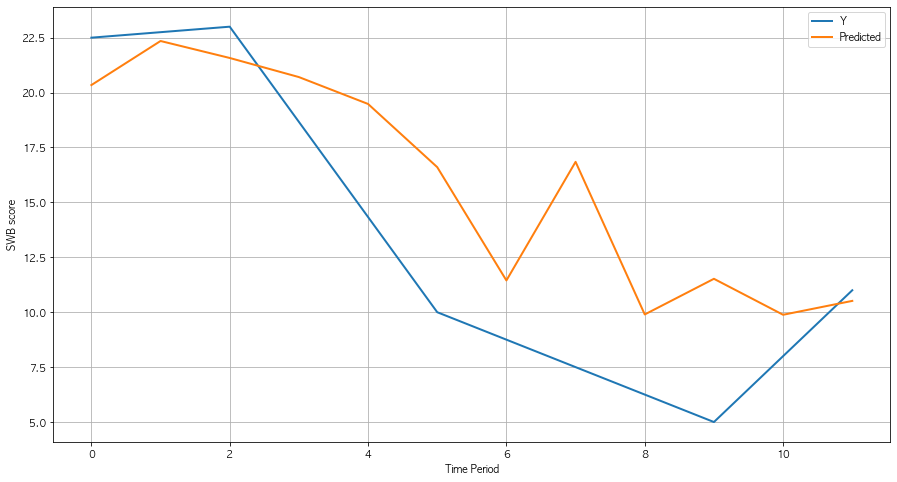

In [258]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    
    ax = plt.plot(testY)
    plt.plot(test_predict)
    plt.legend(['Y', 'Predicted'])

#     plt.plot(testY)
#     plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("SWB score")
    plt.show()